In [1552]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import cv_scores
from csv import DictWriter
from sklearn.model_selection import GridSearchCV
from sklearn.neural_network import MLPRegressor
#from sklearn.svm import SVC
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

In [1553]:
df = pd.read_csv('DataSet_LakasArak.csv')

## Célváltozó létrehozása
###  A lakás négyzetméterárából képződik úgy, hogy a hirdetés feladásának dátuma alapján eliminálásra kerül a lakásárakban észlelhető trend.(órai munka)

In [1554]:
df['created_at']=pd.to_datetime(df['created_at'])

In [1555]:
## négyzetméterár meghatározása
df['nmAr'] = (df['price_created_at']*1000000)/df['property_area']

In [1556]:
stat = df.groupby('created_at',as_index=False).agg({"nmAr":"median"})

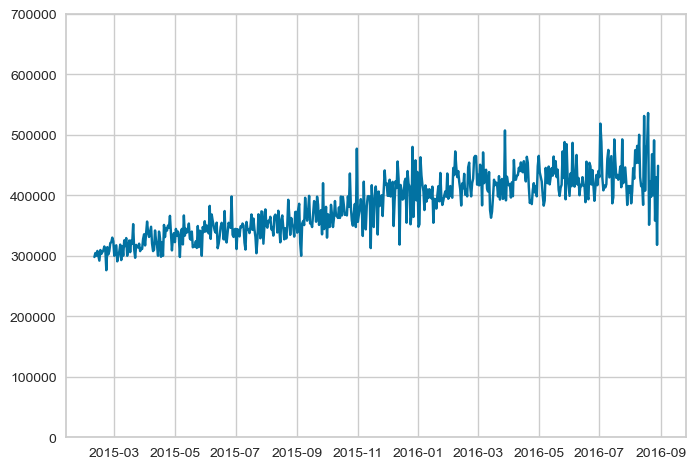

In [1557]:
plt.ylim(0,700000)
plt.plot(stat['created_at'],stat['nmAr'])

### Görbeillesztés, arány számítás, utolsó napra jelenérték számítás
### A jelenérték számítás célja, hogy elimináljuk a trendet, ezáltal a hirdetés feladásának dátuma nem befolyásolja a predikciót.
### A jelenérték számítás során az az elképzelés, hogy x Ft ma többet ér mint holnap. (növekvő trend esetén)
### A módszer során először lineáris regresszió alkalmazva meghatározzuk a trendvonalat a négyzetméterenkénti ár és a feladás napjából számítva
### Minden napra meghatározzuk, az aktuális napra vonatkozó trend szerinti árat
### A jelenértékhez le kell osztani a négyzetméterárat az aktuális trenddel és megszorozni a jelen napra vonatkozó trendértékkel, ezáltal egy olyan árat kapunk, ami mentesül a trend hatása alól

In [1558]:
stat['daynum'] = (stat['created_at']-stat['created_at'].min()).dt.days #567 napa

In [1559]:
minilinreg = LinearRegression()
minilinreg.fit(stat[ ['daynum'] ],stat['nmAr'])   # dataframe type
print(minilinreg.coef_)
print(minilinreg.intercept_)
stat['trend_nmAr'] = minilinreg.predict(stat[['daynum']])

[252.16835777]
311324.87219590397


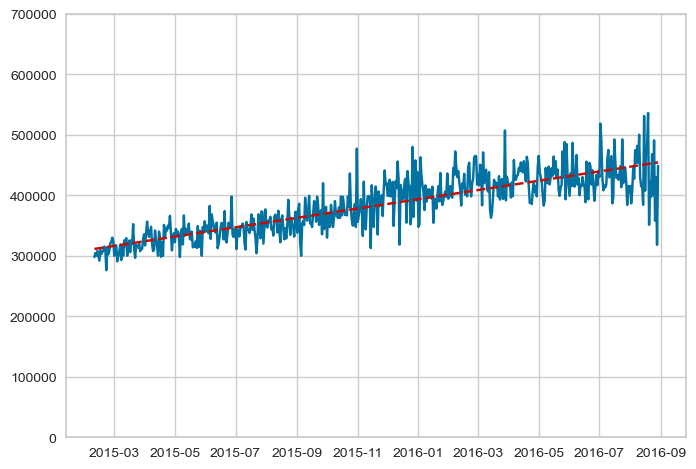

In [1560]:
plt.ylim(0,700000)
plt.plot(stat['created_at'],stat['nmAr'])
plt.plot(stat['created_at'],stat['trend_nmAr'],'r--')

In [1561]:
del stat['nmAr']
del stat['daynum']

In [1562]:
df_jelnmAr = df.merge(stat,on='created_at',how='left')

In [1563]:
df_jelnmAr['jelen_nmAr'] = df_jelnmAr['nmAr']/df_jelnmAr['trend_nmAr']*stat['trend_nmAr'].max()

In [1564]:
df_jelnmAr

,county,city,postcode,property_type,property_subtype,property_condition_type,property_floor,building_floor_count,view_type,orientation,...,created_at,property_area,balcony_area,price_created_at,ad_view_cnt,active_days,nr,nmAr,trend_nmAr,jelen_nmAr
0,Budapest,Budapest XII.,NaN,flat,brick flat (for sale),good,1,NaN,street view,NaN,...,2015-02-09,65.0,0.0,23.5,605.0,119.0,4,361538.461538,311324.872196,527579.077640
1,Budapest,Budapest I.,1016.0,flat,brick flat (for sale),novel,2,NaN,street view,NaN,...,2015-02-09,45.0,0.0,20.0,49.0,25.0,12,444444.444444,311324.872196,648560.568257
2,Budapest,Budapest XVI.,1164.0,flat,brick flat (for sale),novel,1,NaN,garden view,NaN,...,2015-02-09,60.0,0.0,22.0,77.0,77.0,14,366666.666667,311324.872196,535062.468812
3,Budapest,Budapest X.,NaN,flat,brick flat (for sale),good,4,NaN,garden view,NaN,...,2015-02-09,55.0,4.0,11.0,139.0,18.0,21,200000.000000,311324.872196,291852.255716
4,Budapest,Budapest XVIII.,1181.0,flat,prefabricated panel flat (for sale),renewed,6,NaN,NaN,NaN,...,2015-02-09,60.0,3.0,10.2,176.0,69.0,31,170000.000000,311324.872196,248074.417358
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78534,Budapest,Budapest VI.,1063.0,flat,brick flat (for sale),to_be_renovated,1,NaN,NaN,south,...,2016-08-29,65.0,0.0,29.9,10.0,1.0,394169,460000.000000,454304.331054,460000.000000
78535,Budapest,Budapest III.,1031.0,flat,prefabricated panel flat (for sale),missing_info,NaN,NaN,NaN,NaN,...,2016-08-29,35.0,0.0,12.9,17.0,1.0,394174,368571.428571,454304.331054,368571.428571
78536,Budapest,Budapest XIV.,NaN,flat,brick flat (for sale),good,ground floor,NaN,NaN,NaN,...,2016-08-29,25.0,0.0,9.0,56.0,1.0,394176,360000.000000,454304.331054,360000.000000
78537,Budapest,Budapest II.,1024.0,flat,brick flat (for sale),novel,basement,NaN,NaN,east,...,2016-08-29,40.0,0.0,17.5,92.0,1.0,394179,437500.000000,454304.331054,437500.000000


In [1566]:
## célváltozó
celvaltozo = 'jelen_nmAr'

## Modellezés és függvénydefiníciók
#### KFold a hármas keresztvalidációhoz
#### eredmények mentése a result változóba

In [1567]:
def mean_absolute_percentage_error(y_true,y_pred):
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    abs = np.abs((y_true - y_pred)/y_true)
    return np.mean(abs)
mape_scorer = make_scorer(mean_absolute_percentage_error)

In [1568]:
headerList = ['model','new_feature_name','mape_score_mean']
  
# open CSV file and assign header
with open("Result.csv", 'w') as file:
    dw = DictWriter(file, fieldnames=headerList)
    dw.writeheader()
    file.close()

### keresztvalidáció forrás
### https://pieriantraining.com/understanding-cross-validation-in-scikit-learn-with-cross_validate/

In [1854]:
### ez a modell nem került végül használatba
def modellezes_grid(X,y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

    skf = StratifiedKFold(n_splits=3, shuffle=True, random_state=42)
    params = {"C": [0.12, 0.13, 0.14, 0.15]}
        
    #GridSearchCV(linear_model.Lasso(), {'alpha': [0.95]}, n_jobs= 1, cv=5, verbose=1
    clf = GridSearchCV(linear_model.Lasso(), {'alpha': [0.95]}, n_jobs= 1, cv=3, verbose=1)
    clf.fit(X_train, y_train)
    
    print(clf.cv)
    final_clf = clf.best_estimator_
    print(final_clf)
    y_pred = final_clf.predict(X_val)
    print(mean_absolute_percentage_error(y_val, clf.predict(X_val)))
    return clf.cv_results_
### MLP skálázás nélkül
def modellezes_MLP(X,y):

    est = MLPRegressor(activation='relu',alpha=0.001,random_state=20,learning_rate_init=0.01,max_iter=500)
    scores = cross_val_score(est, X, y, cv=3,scoring=mape_scorer)
    return scores

### MLP skálázással
def modellezes_MLP_2(X,y):
    data = X 
    scaler = MinMaxScaler()
    scaler.fit(data)
    normalized = scaler.transform(data)
    est = MLPRegressor(activation='relu',hidden_layer_sizes=(10, 50),alpha=0.001,random_state=20,learning_rate_init=0.01,max_iter=500)
    scores = cross_val_score(est, data, y, cv=3,scoring=mape_scorer)
    return scores


def modellezes_MLP_2_fit(X,y):
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=1)
    est = MLPRegressor(activation='relu',hidden_layer_sizes=(10, 50),alpha=0.001,random_state=20,learning_rate_init=0.001)
    est.fit(X_train,y_train)

    pred = nn.predict(X_test)
    test_set_rsquared = nn.score(X_test, y_test)
    test_set_rmse = np.sqrt(mean_squared_error(y_test, pred))
    print('R_squared value: ', test_set_rsquared)
    print('RMSE: ', test_set_rmse)
    
    return est


def modellezes_linreg(df,bemeno_valtozok,celvaltozo):
    result = []
    model=LinearRegression()
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_results = cross_validate(model, df[bemeno_valtozok], df[celvaltozo], cv=cv,scoring=mape_scorer)
    print(cv_results)
    result.append(cv_results)
    return result

def modellezes_gbm(df,bemeno_valtozok,celvaltozo):
    result = []
    model=GradientBoostingRegressor(n_estimators=100,max_depth=4,random_state=42)
    cv = KFold(n_splits=3, shuffle=True, random_state=42)
    cv_results = cross_validate(model, df[bemeno_valtozok], df[celvaltozo], cv=cv,scoring=mape_scorer)
    print(cv_results)
    result.append(cv_results)
    return result
    
    
def visualization(model,df,bemeno_valtozok,celvaltozo,cv,scoring):
    visualizer = cv_scores(model, df[bemeno_valtozok], df[celvaltozo], cv=cv, scoring=mape_scorer)
    
def save_result_first(result, uj_bemeneti_valtozo):
   
    score_mean = result[0]['test_score'].mean()
    df_result = pd.DataFrame(np.array([uj_bemeneti_valtozo]),columns=['new_feature_name'])
    df_result['mape_score_mean'] = score_mean
    df_result.to_csv("Result.csv") 

def save_result(result, uj_bemeneti_valtozo,model):
    score_mean = result[0]['test_score'].mean()
    with open(r'Result.csv', 'a') as f:
        field_names = ['model','new_feature_name','mape_score_mean']
        writer_object = DictWriter(f, fieldnames=field_names)
        f.write("\n")
        writer_object.writerow({'model':model,'new_feature_name':uj_bemeneti_valtozo,'mape_score_mean':score_mean})
        f.close()
        
def save_result_nn(result, uj_bemeneti_valtozo,model):
    score_mean = result.mean()
    with open(r'Result.csv', 'a') as f:
        field_names = ['model','new_feature_name','mape_score_mean']
        writer_object = DictWriter(f, fieldnames=field_names)
        f.write("\n")
        writer_object.writerow({'model':model,'new_feature_name':uj_bemeneti_valtozo,'mape_score_mean':score_mean})
        f.close()
        
def kiertekelo_fuggveny(df, tipp_oszlop_neve, target_oszlop_neve):
    mean_absolute_error=   (abs(df[tipp_oszlop_neve]-df[target_oszlop_neve])).mean()
    
    MAPE=(abs((df[target_oszlop_neve] - df[tipp_oszlop_neve])/df[target_oszlop_neve])).mean()
    rmse =  np.sqrt( ( (df[tipp_oszlop_neve]-df[target_oszlop_neve])**2 ).mean() )
    print("RMSE",rmse)
    print("MAE:",mean_absolute_error)
    print("MAPE:",MAPE)
    df['tipp_arany']=df[target_oszlop_neve]/df[tipp_oszlop_neve]
    plt.xlim(0,2)
    df['tipp_arany'].hist(bins=300)
    erdekesek=test_df[  (df['tipp_arany']>0.75 ) & (df['tipp_arany']<0.95)]
    print("atnezendok aranya", len(erdekesek)/len(df))  
    return erdekesek

## Adatelőkészítés
### Adathalmaz oszlopainak a megkeverése

In [1570]:
df_shuffle= df_jelnmAr.sample(frac=1, axis=1,random_state=987654321).reset_index(drop=True)

In [1571]:
df_shuffle


,active_days,heating_type,small_room_cnt,property_condition_type,balcony_area,trend_nmAr,nmAr,room_cnt,postcode,county,...,nr,ad_view_cnt,property_type,orientation,city,property_area,property_floor,jelen_nmAr,price_created_at,building_floor_count
0,119.0,tile stove (gas),1.0,good,0.0,311324.872196,361538.461538,2.0,NaN,Budapest,...,4,605.0,flat,NaN,Budapest XII.,65.0,1,527579.077640,23.5,NaN
1,25.0,konvection gas burner,1.0,novel,0.0,311324.872196,444444.444444,1.0,1016.0,Budapest,...,12,49.0,flat,NaN,Budapest I.,45.0,2,648560.568257,20.0,NaN
2,77.0,central heating with own meter,1.0,novel,0.0,311324.872196,366666.666667,2.0,1164.0,Budapest,...,14,77.0,flat,NaN,Budapest XVI.,60.0,1,535062.468812,22.0,NaN
3,18.0,central heating,0.0,good,4.0,311324.872196,200000.000000,2.0,NaN,Budapest,...,21,139.0,flat,NaN,Budapest X.,55.0,4,291852.255716,11.0,NaN
4,69.0,NaN,1.0,renewed,3.0,311324.872196,170000.000000,2.0,1181.0,Budapest,...,31,176.0,flat,NaN,Budapest XVIII.,60.0,6,248074.417358,10.2,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78534,1.0,"gas furnace, circulating hot water",0.0,to_be_renovated,0.0,454304.331054,460000.000000,2.0,1063.0,Budapest,...,394169,10.0,flat,south,Budapest VI.,65.0,1,460000.000000,29.9,NaN
78535,1.0,NaN,0.0,missing_info,0.0,454304.331054,368571.428571,1.0,1031.0,Budapest,...,394174,17.0,flat,NaN,Budapest III.,35.0,NaN,368571.428571,12.9,NaN
78536,1.0,konvection gas burner,0.0,good,0.0,454304.331054,360000.000000,1.0,NaN,Budapest,...,394176,56.0,flat,NaN,Budapest XIV.,25.0,ground floor,360000.000000,9.0,NaN
78537,1.0,"gas furnace, circulating hot water",1.0,novel,0.0,454304.331054,437500.000000,1.0,1024.0,Budapest,...,394179,92.0,flat,east,Budapest II.,40.0,basement,437500.000000,17.5,NaN


### Az egyes változókat (amilyen sorrendben a megtekert adathalmazban láthatók) előkészítem úgy, hogy a modellek fel tudják azt dolgozni 
#### (hiányzó értékek eliminálása, kiugró értékek kezelése, stb). 
#### A df halmazon dolgozom, majd az átalakítás után a df_shuffle halmazba kerül át
#### Az "ad_view_cnt", az "active_days"  és "nr" változókat kihagyom. 
#### Minden egyes változó előkészítése során megnézem, hogy mennyit segít az eddigi eredményekhez képest. Ha ront is, akkor is benthagyom őket a bemenő változók között.
#### Változók sorrendje:

In [1572]:
df_shuffle.columns

Index(['active_days', 'heating_type', 'small_room_cnt',
       'property_condition_type', 'balcony_area', 'trend_nmAr', 'nmAr',
       'room_cnt', 'postcode', 'county', 'created_at', 'property_subtype',
       'garden_access', 'view_type', 'elevator_type', 'nr', 'ad_view_cnt',
       'property_type', 'orientation', 'city', 'property_area',
       'property_floor', 'jelen_nmAr', 'price_created_at',
       'building_floor_count'],
      dtype='object')

In [1573]:
df_shuffle.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 78539 entries, 0 to 78538
Data columns (total 25 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   active_days              78539 non-null  float64       
 1   heating_type             67233 non-null  object        
 2   small_room_cnt           78539 non-null  float64       
 3   property_condition_type  78539 non-null  object        
 4   balcony_area             78539 non-null  float64       
 5   trend_nmAr               78539 non-null  float64       
 6   nmAr                     78539 non-null  float64       
 7   room_cnt                 78539 non-null  float64       
 8   postcode                 49585 non-null  float64       
 9   county                   78539 non-null  object        
 10  created_at               78539 non-null  datetime64[ns]
 11  property_subtype         76880 non-null  object        
 12  garden_access            17200 n

####  Azon oszlopok keresése, amelye tartalmaznak hiányos sorokat

In [1574]:
df_shuffle.isna().sum()

active_days                    0
heating_type               11306
small_room_cnt                 0
property_condition_type        0
balcony_area                   0
trend_nmAr                     0
nmAr                           0
room_cnt                       0
postcode                   28954
county                         0
created_at                     0
property_subtype            1659
garden_access              61339
view_type                  35661
elevator_type              14151
nr                             0
ad_view_cnt                    0
property_type                  0
orientation                30892
city                         559
property_area                  0
property_floor              3793
jelen_nmAr                     0
price_created_at               0
building_floor_count       42110
dtype: int64

#### Fűtés Típusa - részletes vizsgálat(2)
##### - 11306 NaN érték
##### Két fajta átalakítás
##### - A fűtés típus értékeknél a hiányzó értékeket kitöltöm 'other' értékkel + dummy
##### - A fűtés típus értékeknél a hiányzó értékeket kitöltöm a kerületi előfordulás szerint + dummy

In [1575]:
df_shuffle['heating_type'].value_counts()

konvection gas burner                 21358
gas furnace, circulating hot water    14690
district heating                      12958
central heating with own meter         8306
central heating                        5486
electric                               2096
tile stove (gas)                       1224
other                                   972
fan-coil                                131
gas furnace                              12
Name: heating_type, dtype: int64

##### 1. Kitöltés és dummy változók

In [1576]:
df_heating = df_shuffle[['heating_type','jelen_nmAr']].copy()

In [1577]:
df_heating['heating_type'] = df_heating['heating_type'].fillna('other')

In [1578]:

heating_dummies = pd.get_dummies(df_heating['heating_type'], prefix = 'heating_type=', drop_first = True)

df_heating = df_heating.merge(heating_dummies, left_index = True, right_index = True, how = 'left')

In [1579]:
df_heating

,heating_type,jelen_nmAr,heating_type=_central heating with own meter,heating_type=_district heating,heating_type=_electric,heating_type=_fan-coil,heating_type=_gas furnace,"heating_type=_gas furnace, circulating hot water",heating_type=_konvection gas burner,heating_type=_other,heating_type=_tile stove (gas)
0,tile stove (gas),527579.077640,0,0,0,0,0,0,0,0,1
1,konvection gas burner,648560.568257,0,0,0,0,0,0,1,0,0
2,central heating with own meter,535062.468812,1,0,0,0,0,0,0,0,0
3,central heating,291852.255716,0,0,0,0,0,0,0,0,0
4,other,248074.417358,0,0,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...
78534,"gas furnace, circulating hot water",460000.000000,0,0,0,0,0,1,0,0,0
78535,other,368571.428571,0,0,0,0,0,0,0,1,0
78536,konvection gas burner,360000.000000,0,0,0,0,0,0,1,0,0
78537,"gas furnace, circulating hot water",437500.000000,0,0,0,0,0,1,0,0,0


In [1580]:
## redundancia miatt 1 sorral kevesebb bemeneti adat
bemeno_valtozok_dummy = heating_dummies.columns.tolist()[:-1]

In [1581]:
bemeno_valtozok_dummy

['heating_type=_central heating with own meter',
 'heating_type=_district heating',
 'heating_type=_electric',
 'heating_type=_fan-coil',
 'heating_type=_gas furnace',
 'heating_type=_gas furnace, circulating hot water',
 'heating_type=_konvection gas burner',
 'heating_type=_other']

#### Modellezés 

In [1582]:
result = modellezes_linreg(df_heating,bemeno_valtozok_dummy,'jelen_nmAr')
save_result(result,'heating_type_dummy','linreg')

{'fit_time': array([0.46700025, 0.01495838, 0.01097298]), 'score_time': array([0.00299191, 0.00299191, 0.0019927 ]), 'test_score': array([0.28021481, 0.28392538, 0.29081966])}


In [1586]:
result = modellezes_gbm(df_heating,bemeno_valtozok_dummy,'jelen_nmAr')
save_result(result,'heating_type_dummy','gbm')

{'fit_time': array([1.05715418, 1.06410909, 1.06817555]), 'score_time': array([0.47058845, 0.03590178, 0.03590727]), 'test_score': array([0.28020176, 0.28392307, 0.29082972])}


[{'fit_time': array([1.19518447, 1.05421567, 1.06514621]),
  'score_time': array([0.00372076, 0.00095892, 0.001055  ]),
  'test_score': array([nan, nan, nan])}]

In [1587]:
result = modellezes_MLP_2(df_heating[bemeno_valtozok_dummy],df_heating['jelen_nmAr'])
save_result_nn(result,'heating_type_dummy','MLPReg')


##### 2. Típusok eloszlása

Text(0, 0.5, 'Mennyiség')

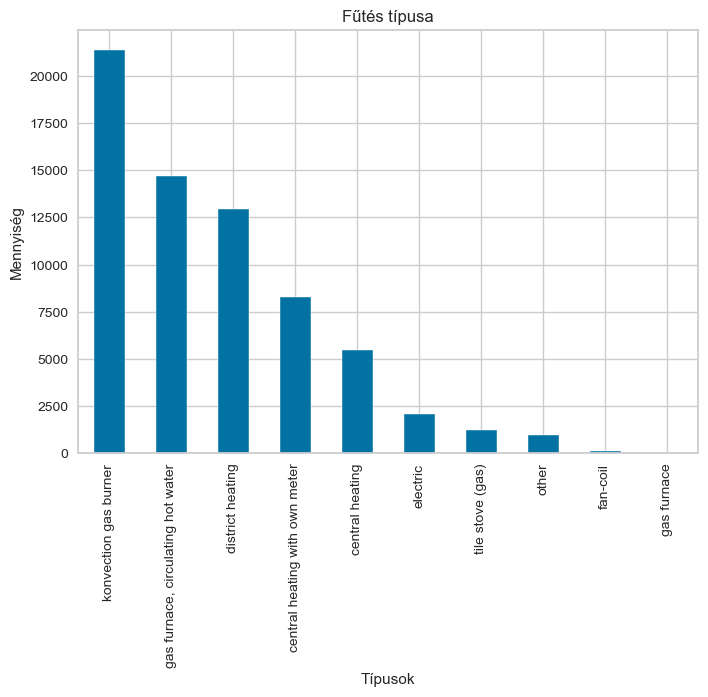

In [1588]:
df_shuffle['heating_type'].value_counts().plot(kind='bar')
plt.title("Fűtés típusa")
plt.xlabel("Típusok")
plt.ylabel("Mennyiség")

In [1589]:
df_heating_city = df_shuffle.copy()
df_heating_city = df_heating_city.drop(df_corr[df_corr['heating_type'].isnull()].index)

In [1590]:
### Fűtéstípus eloszlása a kerület szerint
### az egyes kerületek összes előfordulása
df_all_city = df_heating_city['city'].value_counts().reset_index()

In [1591]:
df_all_city.columns=['city','sum']

In [1592]:
# minden kerületben megnézem a leggyakrabban előforduló fűtéstípust
df_heating_sum = (df_heating_city.groupby('city')['heating_type'].value_counts()
         .rename('counts').reset_index()
         .drop_duplicates('city'))

In [1593]:
# végül összekötöm a leggyakoribb fűtéstípus számát az adott kerületben, és az összes előforduló lakást az adott kerületben
df_heating_sum=df_heating_sum.merge(df_all_city,on='city',how='right')

In [1594]:
# megmutatja, hogy mekkora az esély, hogy az adott kerületben az adott fűtéstípus van
df_heating_sum['chance'] = df_heating_sum.apply(lambda x: (x['counts']/x['sum'])*100,axis=1)

In [1595]:
dict_df = df_heating_sum.set_index('city')['heating_type'].to_dict()  
dict_df

{'Budapest XIII.': 'konvection gas burner',
 'Budapest XIV.': 'konvection gas burner',
 'Budapest XI.': 'district heating',
 'Budapest VII.': 'konvection gas burner',
 'Budapest III.': 'district heating',
 'Budapest VIII.': 'konvection gas burner',
 'Budapest VI.': 'konvection gas burner',
 'Budapest IX.': 'konvection gas burner',
 'Budapest IV.': 'district heating',
 'Budapest II.': 'gas furnace, circulating hot water',
 'Budapest XV.': 'district heating',
 'Budapest X.': 'district heating',
 'Budapest V.': 'gas furnace, circulating hot water',
 'Budapest XII.': 'gas furnace, circulating hot water',
 'Budapest XVIII.': 'central heating with own meter',
 'Budapest XXI.': 'district heating',
 'Budapest XIX.': 'district heating',
 'Budapest XX.': 'konvection gas burner',
 'Budapest I.': 'gas furnace, circulating hot water',
 'Budapest XVII.': 'district heating',
 'Budapest XVI.': 'konvection gas burner',
 'Budapest XXII.': 'konvection gas burner',
 'Budapest XXIII.': 'gas furnace, circul

In [1597]:
# a hiányzó értékek helyére a kerület szerint írom be az adott fűtéstípust
df_heating_city['heating_type'] = df_heating_city['heating_type'].fillna(df_heating_city['city'].map(dict_df))

In [1598]:
df_heating_city.isna().sum()

active_days                    0
heating_type                  47
small_room_cnt                 0
property_condition_type        0
balcony_area                   0
trend_nmAr                     0
nmAr                           0
room_cnt                       0
postcode                   28954
county                         0
created_at                     0
property_subtype            1659
garden_access              61339
view_type                  35661
elevator_type              14151
nr                             0
ad_view_cnt                    0
property_type                  0
orientation                30892
city                         559
property_area                  0
property_floor              3793
jelen_nmAr                     0
price_created_at               0
building_floor_count       42110
dtype: int64

In [1599]:
# maradék üres sorok kitöltése 'other' mezővel + dummy
df_heating_city['heating_type'] = df_heating_city['heating_type'].fillna('other')
heating_dummies_2 = pd.get_dummies(df_heating_city['heating_type'], prefix = 'heating_type=', drop_first = True)
df_heating_city = df_heating_city.merge(heating_dummies_2, left_index = True, right_index = True, how = 'left')
bemeno_valtozok_dummy = heating_dummies_2.columns.tolist()

In [1629]:
df_heating_sum

,city,heating_type,counts,sum,chance
0,Budapest XIII.,konvection gas burner,2113,8567,24.664410
1,Budapest XIV.,konvection gas burner,2194,8434,26.013754
2,Budapest XI.,district heating,1579,7001,22.553921
3,Budapest VII.,konvection gas burner,3296,6064,54.353562
4,Budapest III.,district heating,1811,5646,32.075806
5,Budapest VIII.,konvection gas burner,2531,5460,46.355311
6,Budapest VI.,konvection gas burner,1980,4577,43.259777
7,Budapest IX.,konvection gas burner,1323,3877,34.124323
8,Budapest IV.,district heating,1271,3376,37.648104
9,Budapest II.,"gas furnace, circulating hot water",1206,3274,36.835675


#### Modellezés 

In [1601]:
result = modellezes_linreg(df_heating_city,bemeno_valtozok_dummy,'jelen_nmAr')
save_result(result,'heating_type_citydummy','linreg')

{'fit_time': array([0.38371229, 0.01093173, 0.01094341]), 'score_time': array([0.00298762, 0.00199413, 0.00199437]), 'test_score': array([0.27836331, 0.28171143, 0.2891625 ])}


In [1602]:
result = modellezes_gbm(df_heating_city,bemeno_valtozok_dummy,'jelen_nmAr')
save_result(result,'heating_type_citydummy','gbm')

{'fit_time': array([1.06916213, 1.01626396, 1.03122401]), 'score_time': array([0.03688765, 0.03490639, 0.03393912]), 'test_score': array([0.27835158, 0.28171919, 0.28917889])}


#### Jobb eredményhez használt változók a bemenő változókhoz kerülnek
##### A jobb eredményt(2 ezrelék különbséggel) a második esetben értem el

In [1607]:
bemeneti_valtozok = heating_dummies_2.columns.tolist()

In [1642]:
df_shuffle.drop(['heating_type=_central heating with own meter_x',
       'heating_type=_district heating_x', 'heating_type=_electric_x',
       'heating_type=_fan-coil_x', 'heating_type=_gas furnace_x',
       'heating_type=_gas furnace, circulating hot water_x',
       'heating_type=_konvection gas burner_x', 'heating_type=_other_x',
       'heating_type=_tile stove (gas)_x',
       'heating_type=_central heating with own meter_y',
       'heating_type=_district heating_y', 'heating_type=_electric_y',
       'heating_type=_fan-coil_y', 'heating_type=_gas furnace_y',
       'heating_type=_gas furnace, circulating hot water_y',
       'heating_type=_konvection gas burner_y', 'heating_type=_other_y',
       'heating_type=_tile stove (gas)_y'],axis=1,inplace=True)

In [1633]:
# a vizsgált adathalmazhoz hozzáadva a második esetben kreált dummy változókat
df_shuffle = df_shuffle.merge(heating_dummies_2, left_index = True, right_index = True, how = 'left')

In [1643]:
df_shuffle.columns

Index(['active_days', 'heating_type', 'small_room_cnt',
       'property_condition_type', 'balcony_area', 'trend_nmAr', 'nmAr',
       'room_cnt', 'postcode', 'county', 'created_at', 'property_subtype',
       'garden_access', 'view_type', 'elevator_type', 'nr', 'ad_view_cnt',
       'property_type', 'orientation', 'city', 'property_area',
       'property_floor', 'jelen_nmAr', 'price_created_at',
       'building_floor_count', 'condition_mapping', 'condition_dummy',
       'condition=_good', 'condition=_medium', 'condition=_missing_info',
       'condition=_new_construction', 'condition=_novel', 'condition=_renewed',
       'condition=_to_be_renovated', 'condition=_under_construction',
       'heating_type=_central heating with own meter',
       'heating_type=_district heating', 'heating_type=_electric',
       'heating_type=_fan-coil', 'heating_type=_gas furnace',
       'heating_type=_gas furnace, circulating hot water',
       'heating_type=_konvection gas burner', 'heating_type=_

#### Kis szobák száma
##### nincsenek üres értékek, megfelelő a formátum

In [1605]:
df_shuffle['small_room_cnt'].value_counts()

0.0    44995
1.0    24067
2.0     8801
3.0      401
4.0      275
Name: small_room_cnt, dtype: int64

In [1614]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),"small_room_cnt")

#### Állapot - részletes vizsgálat(2)
##### 1. One-hot encoding - Dummy változók
##### 2. integer encoding - Mapping


In [1616]:
# nincs hiányos adat
df_shuffle['property_condition_type'].isna().sum()

0

In [1617]:
df_shuffle['property_condition_type'].value_counts()

good                  26731
novel                 15698
renewed               12140
medium                10958
to_be_renovated        6113
missing_info           3555
new_construction       2940
can_move_in             394
under_construction       10
Name: property_condition_type, dtype: int64

In [1618]:
df_shuffle['condition_mapping'] = df_shuffle['property_condition_type'].copy()
df_shuffle['condition_dummy'] = df_shuffle['property_condition_type'].copy()

In [1619]:
con_value= df['property_condition_type'].value_counts().index.tolist()

In [1620]:
# értékek átalakítása mappinggel

mapping = {con_value[0]: 1, con_value[1]: 2,con_value[2]:3,con_value[3]:4,con_value[4]:5,con_value[5]:6,con_value[6]:7,con_value[7]:8,con_value[8]:9}
df_shuffle = df_shuffle.replace({'condition_mapping': mapping})

In [1621]:
# one-hot encoding
heating_dummies = pd.get_dummies(df_shuffle['condition_dummy'], prefix = 'condition=', drop_first = True)
df_shuffle = df_shuffle.merge(heating_dummies, left_index = True, right_index = True, how = 'left')
bemeno_valtozok_dummy = heating_dummies.columns.tolist()

####  Állapot modellezés

##### 1. Dummy

In [1623]:
bemeno_valtozok_dummy_test = bemeneti_valtozok + bemeno_valtozok_dummy

In [1646]:
df_shuffle.columns

Index(['active_days', 'heating_type', 'small_room_cnt',
       'property_condition_type', 'balcony_area', 'trend_nmAr', 'nmAr',
       'room_cnt', 'postcode', 'county', 'created_at', 'property_subtype',
       'garden_access', 'view_type', 'elevator_type', 'nr', 'ad_view_cnt',
       'property_type', 'orientation', 'city', 'property_area',
       'property_floor', 'jelen_nmAr', 'price_created_at',
       'building_floor_count', 'condition_mapping', 'condition_dummy',
       'condition=_good', 'condition=_medium', 'condition=_missing_info',
       'condition=_new_construction', 'condition=_novel', 'condition=_renewed',
       'condition=_to_be_renovated', 'condition=_under_construction',
       'heating_type=_central heating with own meter',
       'heating_type=_district heating', 'heating_type=_electric',
       'heating_type=_fan-coil', 'heating_type=_gas furnace',
       'heating_type=_gas furnace, circulating hot water',
       'heating_type=_konvection gas burner', 'heating_type=_

In [1653]:
result = modellezes_linreg(df_shuffle,bemeno_valtozok_dummy_test,'jelen_nmAr')
save_result(result,'condition_dummy','linreg')

{'fit_time': array([0.65609694, 0.03288627, 0.02393794]), 'score_time': array([0.00400829, 0.00398874, 0.00301862]), 'test_score': array([0.26520664, 0.26708682, 0.27430907])}


In [1654]:
result = modellezes_gbm(df_shuffle,bemeno_valtozok_dummy_test,'jelen_nmAr')
save_result(result,'condition_dummy','gbm')

{'fit_time': array([2.48337722, 2.39654636, 2.38561296]), 'score_time': array([0.04788566, 0.04388237, 0.0458777 ]), 'test_score': array([0.25830013, 0.26059959, 0.26757567])}


##### 2. Mapping

In [1649]:
bemeno_valtozok_mapping_test = bemeneti_valtozok

In [1650]:
bemeno_valtozok_mapping_test.insert(len(bemeno_valtozok_mapping_test),"condition_mapping")

In [1655]:
result = modellezes_linreg(df_shuffle,bemeno_valtozok_mapping_test,'jelen_nmAr')
save_result(result,'condition_mapping','linreg')

{'fit_time': array([0.02094412, 0.01994681, 0.02393532]), 'score_time': array([0.00398874, 0.00399113, 0.0039897 ]), 'test_score': array([0.27629984, 0.27893774, 0.28712754])}


In [1656]:
result = modellezes_gbm(df_shuffle,bemeno_valtozok_mapping_test,'jelen_nmAr')
save_result(result,'condition_mapping','gbm')

{'fit_time': array([1.96079636, 1.8710196 , 1.7703023 ]), 'score_time': array([0.04985929, 0.04684782, 0.04785705]), 'test_score': array([0.25868033, 0.26121603, 0.26788245])}


#### Jobb eredményhez használt változók a bemenő változókhoz kerülnek
##### A dummy változókkal jobb eredményt ért el a modell

In [1660]:
bemeneti_valtozok = bemeno_valtozok_dummy_test

In [1661]:
bemeneti_valtozok

['heating_type=_central heating with own meter',
 'heating_type=_district heating',
 'heating_type=_electric',
 'heating_type=_fan-coil',
 'heating_type=_gas furnace',
 'heating_type=_gas furnace, circulating hot water',
 'heating_type=_konvection gas burner',
 'heating_type=_other',
 'heating_type=_tile stove (gas)',
 'small_room_cnt',
 'condition=_good',
 'condition=_medium',
 'condition=_missing_info',
 'condition=_new_construction',
 'condition=_novel',
 'condition=_renewed',
 'condition=_to_be_renovated',
 'condition=_under_construction']

In [1662]:
df_shuffle
## az értékek szerepelnek benne

,active_days,heating_type,small_room_cnt,property_condition_type,balcony_area,trend_nmAr,nmAr,room_cnt,postcode,county,...,condition=_under_construction,heating_type=_central heating with own meter,heating_type=_district heating,heating_type=_electric,heating_type=_fan-coil,heating_type=_gas furnace,"heating_type=_gas furnace, circulating hot water",heating_type=_konvection gas burner,heating_type=_other,heating_type=_tile stove (gas)
0,119.0,tile stove (gas),1.0,good,0.0,311324.872196,361538.461538,2.0,NaN,Budapest,...,0,0,0,0,0,0,0,0,0,1
1,25.0,konvection gas burner,1.0,novel,0.0,311324.872196,444444.444444,1.0,1016.0,Budapest,...,0,0,0,0,0,0,0,1,0,0
2,77.0,central heating with own meter,1.0,novel,0.0,311324.872196,366666.666667,2.0,1164.0,Budapest,...,0,1,0,0,0,0,0,0,0,0
3,18.0,central heating,0.0,good,4.0,311324.872196,200000.000000,2.0,NaN,Budapest,...,0,0,0,0,0,0,0,0,0,0
4,69.0,central heating with own meter,1.0,renewed,3.0,311324.872196,170000.000000,2.0,1181.0,Budapest,...,0,1,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
78534,1.0,"gas furnace, circulating hot water",0.0,to_be_renovated,0.0,454304.331054,460000.000000,2.0,1063.0,Budapest,...,0,0,0,0,0,0,1,0,0,0
78535,1.0,district heating,0.0,missing_info,0.0,454304.331054,368571.428571,1.0,1031.0,Budapest,...,0,0,1,0,0,0,0,0,0,0
78536,1.0,konvection gas burner,0.0,good,0.0,454304.331054,360000.000000,1.0,NaN,Budapest,...,0,0,0,0,0,0,0,1,0,0
78537,1.0,"gas furnace, circulating hot water",1.0,novel,0.0,454304.331054,437500.000000,1.0,1024.0,Budapest,...,0,0,0,0,0,0,1,0,0,0


#### Balcon  

In [1663]:
df_shuffle['balcony_area'].value_counts()

0.0     52682
4.0      6935
3.0      4745
5.0      2802
2.0      2438
        ...  
64.0        1
86.0        1
60.0        1
58.0        1
69.0        1
Name: balcony_area, Length: 83, dtype: int64

In [1664]:
df_shuffle['balcony_area'].isna().sum()

0

In [1665]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),"balcony_area")

#### Szobák száma

In [1667]:
df_shuffle['room_cnt'].value_counts()

1.0    45125
2.0    29281
3.0     3747
0.0      305
4.0       69
5.0        9
7.0        2
6.0        1
Name: room_cnt, dtype: int64

In [1668]:
df_shuffle['room_cnt'].isna().sum()

0

In [1669]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),"room_cnt")

#### Irányítószám - részletes vizsgálat
##### 28954 Nan érték

In [1670]:
df_shuffle['postcode'].value_counts()

1039.0    1396
1135.0    1366
1134.0     983
1156.0     980
1144.0     967
          ... 
1215.0      18
1046.0      18
1185.0       3
1110.0       3
1239.0       2
Name: postcode, Length: 161, dtype: int64

In [1671]:
df_shuffle['postcode']=df_shuffle['postcode'].fillna(1000).apply(lambda x: int(str(x)[1:3]))

In [1672]:
stat = df_shuffle.groupby('city',as_index=False).agg({'postcode':'max'})  
stat

,city,postcode
0,Budapest I.,1
1,Budapest II.,2
2,Budapest III.,3
3,Budapest IV.,4
4,Budapest IX.,9
5,Budapest V.,5
6,Budapest VI.,6
7,Budapest VII.,7
8,Budapest VIII.,8
9,Budapest X.,19


In [1673]:
# javitjuk a kerulet hibat kezzel
stat.iloc[9,1]=10
stat.iloc[12,1]=13

In [1674]:
stat.columns=['city','ker_code_from_postcode']

In [1675]:
# hozzáfűzzük a kerület sorszámát 
df_shuffle=df_shuffle.merge(stat,on='city',how='left')

In [1676]:
# Hiányzó értékek kitöltése 0-val
df_shuffle['ker_code_from_postcode'].fillna(0,inplace=True)

In [1677]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),"ker_code_from_postcode")

In [1678]:
result = modellezes_linreg(df_shuffle,bemeno_valtozok,'jelen_nmAr')
save_result(result,'ker_code_from_postcode','linreg')

{'fit_time': array([0.01097107, 0.01196909, 0.00997376]), 'score_time': array([0.00299144, 0.00199389, 0.00199556]), 'test_score': array([0.27855305, 0.2819111 , 0.28959334])}


In [1679]:
result = modellezes_gbm(df_shuffle,bemeno_valtozok,'jelen_nmAr')
save_result(result,'ker_code_from_postcode','gbm')

{'fit_time': array([1.00833011, 1.03225422, 1.00135064]), 'score_time': array([0.03588462, 0.03688407, 0.03588343]), 'test_score': array([0.27854208, 0.28193463, 0.28963895])}


In [ ]:
### result.csv alapján minimálisan ront az eddigi értékeken

#### Város
##### Elhagyható változó, nem hordoz plusz információt

In [1680]:
df_shuffle['county'].value_counts()

Budapest    78539
Name: county, dtype: int64

#### Milyen napon tették ki a hirdetést? Melyik napon? - részletes vizsgálat(2)
##### 1. Dátum feldarabolása 3 különböző oszlopba


In [1681]:
df_shuffle["time"] = pd.to_datetime(df_shuffle["created_at"])

In [1682]:
df_shuffle['year'] = df_shuffle['time'].dt.year
df_shuffle['month'] = df_shuffle['time'].dt.month
df_shuffle['day'] = df_shuffle['time'].dt.day


In [1686]:
bemeno_valtozok_time = bemeneti_valtozok.copy()

In [1687]:
bemeno_valtozok_time.insert(len(bemeno_valtozok_time),"year")
bemeno_valtozok_time.insert(len(bemeno_valtozok_time),"month")
bemeno_valtozok_time.insert(len(bemeno_valtozok_time),"day")

In [1689]:
result = modellezes_linreg(df_shuffle,bemeno_valtozok_time,'jelen_nmAr')
save_result(result,'year_month_day','linreg')

{'fit_time': array([0.4277935 , 0.03089166, 0.03390908]), 'score_time': array([0.00400043, 0.00398779, 0.00498652]), 'test_score': array([0.23783841, 0.24397119, 0.24733769])}


In [1690]:
result = modellezes_gbm(df_shuffle,bemeno_valtozok_time,'jelen_nmAr')
save_result(result,'year_month_day','gbm')

{'fit_time': array([4.97867346, 4.77724147, 4.71738482]), 'score_time': array([0.05684733, 0.04986548, 0.05085325]), 'test_score': array([0.16658206, 0.17276319, 0.17490155])}


##### 2. dátum helyett csak az eddig eltelt napok számát írni

In [1699]:
stat = df_shuffle.groupby('time',as_index=False).agg({"nmAr":"median"})

In [1704]:
stat

,time,daynum
0,2015-02-09,0
1,2015-02-10,1
2,2015-02-11,2
3,2015-02-12,3
4,2015-02-13,4
...,...,...
563,2016-08-25,563
564,2016-08-26,564
565,2016-08-27,565
566,2016-08-28,566


In [1701]:
del stat['nmAr']

In [1703]:
stat['daynum'] = (stat['time']-stat['time'].min()).dt.days #567 napa

In [1705]:
df_shuffle = df_shuffle.merge(stat,on='time',how='left')

In [1706]:
bemeno_valtozok_daynum = bemeneti_valtozok.copy()

In [1707]:
bemeno_valtozok_daynum.insert(len(bemeno_valtozok_daynum),"daynum")

In [1708]:
result = modellezes_linreg(df_shuffle,bemeno_valtozok_daynum,'jelen_nmAr')
save_result(result,'daynum','linreg')

{'fit_time': array([0.04188752, 0.044842  , 0.0448792 ]), 'score_time': array([0.00498652, 0.0059824 , 0.00498652]), 'test_score': array([0.23785402, 0.24397226, 0.24731391])}


In [1709]:
result = modellezes_gbm(df_shuffle,bemeno_valtozok_daynum,'jelen_nmAr')
save_result(result,'daynum','gbm')

{'fit_time': array([6.16248178, 5.7725811 , 5.8344171 ]), 'score_time': array([0.04987979, 0.05482626, 0.04986501]), 'test_score': array([0.16757322, 0.17273466, 0.17450263])}


#### Jobb eredményhez használt változók a bemenő változókhoz kerülnek
##### jobb eredményt ért el, ha az első módszert használom

In [1716]:
bemeneti_valtozok = bemeno_valtozok_time.copy()

#### Lakás altípus
##### 1659 NaN érték

In [1718]:
# melyik tipusu lakasbol mennyi van
df_shuffle['property_subtype'].value_counts()

brick flat (for sale)                  57081
prefabricated panel flat (for sale)    19799
Name: property_subtype, dtype: int64

In [1719]:
# hiányzó sorok kitöltése
df_shuffle['property_subtype'] = df_shuffle['property_subtype'].fillna('other')

In [1720]:
# Mapping
codes = {'other':0, 'brick flat (for sale)':1, 'prefabricated panel flat (for sale)':2}
df_shuffle['property_subtype'] = df_shuffle['property_subtype'].map(codes)

In [1721]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),"property_subtype")

#### Kert
##### 61339 Nan érték

In [1723]:
df_shuffle['garden_access'].value_counts()

none    14417
yes      2783
Name: garden_access, dtype: int64

In [1724]:
# flag változó
df_shuffle['garden_access'] = df_shuffle['garden_access'].apply(lambda x: 1 if x=="yes" else 0)


In [1751]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),"garden_access")

#### Nézet
##### 35661 NaN érték

In [1726]:
df_shuffle['view_type'].value_counts()

street view       17183
garden view       11090
courtyard view     9463
panoramic          5142
Name: view_type, dtype: int64

In [1727]:
# hiányzó sorok kitöltése
df_shuffle['view_type'] = df_shuffle['view_type'].fillna('other')

In [1728]:
### Mapping
codes = {'other':0, 'street view':1, 'garden view':2,'courtyard view':3, 'panoramic':4}
df_shuffle['view_type'] = df_shuffle['view_type'].map(codes)

In [1729]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),"view_type")

#### Lift
##### 14151 NaN érték

In [1730]:
df_shuffle['elevator_type'].value_counts()

yes     35062
none    29326
Name: elevator_type, dtype: int64

In [1731]:
# ha van lift 1, ha nincs vagy hiányzó érték, akkor 0
df_shuffle['elevator_type'] = df_shuffle['elevator_type'].apply(lambda x: 1 if x=="yes" else 0)

In [1732]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),"elevator_type")

#### Lakás típusa

In [1733]:
## elhagyható változó
df_shuffle['property_type'].value_counts()

flat    78539
Name: property_type, dtype: int64

#### Fekvés - részletes vizsgálat(2) 
##### 30892 NaN érték

##### Feltevés: Azonos kerületben azonos fekvésű épületek vannak

In [1734]:
df_shuffle['orientation'].value_counts()

east          9872
south-west    8926
west          8564
south-east    7080
south         6670
north-east    2980
north-west    2529
north         1026
Name: orientation, dtype: int64

In [1735]:
## összesítem a kerületszámokat az ott leggyakrabban előforduló tájolás értékkel
df_ori = (df_shuffle.groupby('ker_code_from_postcode')['orientation'].value_counts()
         .rename('counts').reset_index()
         .drop_duplicates('ker_code_from_postcode'))

In [1736]:
df_ori

,ker_code_from_postcode,orientation,counts
0,0.0,east,61
8,1.0,east,183
16,2.0,east,386
24,3.0,east,1085
32,4.0,east,512
40,5.0,west,304
48,6.0,south-east,558
56,7.0,south-west,620
64,8.0,east,680
72,9.0,south-west,448


In [1737]:
dict_df = df_ori.set_index('ker_code_from_postcode')['orientation'].to_dict()  
dict_df

{0.0: 'east',
 1.0: 'east',
 2.0: 'east',
 3.0: 'east',
 4.0: 'east',
 5.0: 'west',
 6.0: 'south-east',
 7.0: 'south-west',
 8.0: 'east',
 9.0: 'south-west',
 10.0: 'south-west',
 11.0: 'east',
 12.0: 'south-west',
 13.0: 'west',
 14.0: 'south-west',
 15.0: 'south-west',
 16.0: 'south-west',
 17.0: 'south',
 18.0: 'east',
 19.0: 'south-east',
 20.0: 'south-west',
 21.0: 'east',
 22.0: 'east',
 23.0: 'south-west'}

In [1738]:
df_shuffle['ori_from_postcode'] = df_shuffle['orientation'].copy()

In [1739]:
df_shuffle['ori_from_postcode'] = df_shuffle['ori_from_postcode'].fillna(df_shuffle['ker_code_from_postcode'].map(dict_df))

In [1741]:
# maradék üres sorok kitöltése 'other' mezővel
df_shuffle['ori_from_postcode'] = df_shuffle['ori_from_postcode'].fillna('other')

In [1742]:
# one-hot encoding
ori_dummies = pd.get_dummies(df_shuffle['ori_from_postcode'], prefix = 'ori=', drop_first = True)
df_shuffle = df_shuffle.merge(ori_dummies, left_index = True, right_index = True, how = 'left')
bemeno_valtozok_dummy_ori = ori_dummies.columns.tolist()

In [1744]:
df_shuffle.columns

Index(['active_days', 'heating_type', 'small_room_cnt',
       'property_condition_type', 'balcony_area', 'trend_nmAr', 'nmAr',
       'room_cnt', 'postcode', 'county', 'created_at', 'property_subtype',
       'garden_access', 'view_type', 'elevator_type', 'nr', 'ad_view_cnt',
       'property_type', 'orientation', 'city', 'property_area',
       'property_floor', 'jelen_nmAr', 'price_created_at',
       'building_floor_count', 'condition_mapping', 'condition_dummy',
       'condition=_good', 'condition=_medium', 'condition=_missing_info',
       'condition=_new_construction', 'condition=_novel', 'condition=_renewed',
       'condition=_to_be_renovated', 'condition=_under_construction',
       'heating_type=_central heating with own meter',
       'heating_type=_district heating', 'heating_type=_electric',
       'heating_type=_fan-coil', 'heating_type=_gas furnace',
       'heating_type=_gas furnace, circulating hot water',
       'heating_type=_konvection gas burner', 'heating_type=_

In [1754]:
bemeno_valtozok_ori = bemeneti_valtozok.copy()

In [1755]:
bemeno_valtozok_ori = bemeno_valtozok_ori + bemeno_valtozok_dummy_ori

In [1756]:
bemeno_valtozok_ori

['heating_type=_central heating with own meter',
 'heating_type=_district heating',
 'heating_type=_electric',
 'heating_type=_fan-coil',
 'heating_type=_gas furnace',
 'heating_type=_gas furnace, circulating hot water',
 'heating_type=_konvection gas burner',
 'heating_type=_other',
 'heating_type=_tile stove (gas)',
 'small_room_cnt',
 'condition=_good',
 'condition=_medium',
 'condition=_missing_info',
 'condition=_new_construction',
 'condition=_novel',
 'condition=_renewed',
 'condition=_to_be_renovated',
 'condition=_under_construction',
 'balcony_area',
 'room_cnt',
 'ker_code_from_postcode',
 'year',
 'month',
 'day',
 'property_subtype',
 'view_type',
 'elevator_type',
 'garden_access',
 'ori=_north',
 'ori=_north-east',
 'ori=_north-west',
 'ori=_south',
 'ori=_south-east',
 'ori=_south-west',
 'ori=_west']

In [1757]:
result = modellezes_linreg(df_shuffle,bemeno_valtozok_ori,'jelen_nmAr')
save_result(result,'ori_dummy','linreg')

{'fit_time': array([0.6021049 , 0.04388309, 0.04487872]), 'score_time': array([0.00498533, 0.00498748, 0.00598478]), 'test_score': array([0.23098073, 0.23642116, 0.23938165])}


In [1758]:
result = modellezes_gbm(df_shuffle,bemeno_valtozok_ori,'jelen_nmAr')
save_result(result,'ori_dummy','gbm')

{'fit_time': array([6.64222717, 6.44276595, 6.35702848]), 'score_time': array([0.0538559 , 0.05784392, 0.06082773]), 'test_score': array([0.15879968, 0.16369019, 0.16530973])}


#### Város és kerület - részletes vizsgálat(3)
##### 559 NaN érték
##### irányítószámhoz hasonló értékek

In [1759]:
df_shuffle['roman']=df_shuffle['city'].fillna('Budapest XXIV.').apply(lambda x: x.split()[1].replace('.',''))

stat_ker = df_shuffle.groupby('city',as_index=False).agg({'roman':'max'})  
stat_ker

,city,roman
0,Budapest I.,I
1,Budapest II.,II
2,Budapest III.,III
3,Budapest IV.,IV
4,Budapest IX.,IX
5,Budapest V.,V
6,Budapest VI.,VI
7,Budapest VII.,VII
8,Budapest VIII.,VIII
9,Budapest X.,X


In [1760]:
stat_ker.columns=['city','city_to_ker_code']
stat_ker

,city,city_to_ker_code
0,Budapest I.,I
1,Budapest II.,II
2,Budapest III.,III
3,Budapest IV.,IV
4,Budapest IX.,IX
5,Budapest V.,V
6,Budapest VI.,VI
7,Budapest VII.,VII
8,Budapest VIII.,VIII
9,Budapest X.,X


In [1761]:
## Arab számmá alakítás
def decode_roman_numeral(roman):
    """Calculate the numeric value of a Roman numeral (in capital letters)"""
    trans = {'I': 1, 'V': 5, 'X': 10, 'L': 50, 'C': 100, 'D': 500, 'M': 1000}
    values = [trans[r] for r in roman]
    return sum(
        val if val >= next_val else -val
        for val, next_val in zip(values[:-1], values[1:])
    ) + values[-1]

In [1762]:
stat_ker['city_to_ker_code'] = stat_ker['city_to_ker_code'].apply(lambda x: decode_roman_numeral(x))

#### Lakás nagysága
##### megfelelő típus, nincseek hiányos sorok

In [1764]:
df_shuffle['property_area'].value_counts()

50.0    11947
55.0    11943
45.0     8838
35.0     8816
60.0     7973
65.0     7342
40.0     6727
30.0     5799
70.0     4938
25.0     3403
20.0      566
15.0      174
10.0       60
5.0        13
Name: property_area, dtype: int64

In [1765]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),"property_area")

#### Lakás emelete - részletes vizsgálat(2)
##### 3793 NaN érték
#### A két fajta átalakítás:
##### Az emeletet először a subtype és building_floor mezőkből következtetem ki
##### Másodszor az üres értékek helyére simán medián értékeket írok

In [1766]:
df_shuffle['property_floor'].value_counts()

1                  14687
2                  12890
ground floor       12346
3                  10716
4                   6632
mezzanine floor     3677
5                   3492
6                   2530
7                   1841
8                   1712
10                  1681
9                   1615
10 plus              486
basement             441
Name: property_floor, dtype: int64

In [1767]:
def switch(x):
    if x=='mezzanine floor':
        x='0.5'
    elif x=='ground floor':
        x='0'
    elif x=='10 plus':
        x='10'
    elif x=='basement':
        x='-1'   
    elif x=='more than 10':
        x='11'
    return x

In [1768]:
## stringek átalakítás
df_shuffle['property_floor'] = df_shuffle['property_floor'].apply(lambda x: switch(x))
df_shuffle['building_floor_count'] = df_shuffle['building_floor_count'].apply(lambda x: switch(x))

In [1769]:

df_shuffle['emelet'] = df_shuffle['property_floor'].copy()
#plt.plot(df[df['property_floor']>5], df['building floor count'])


In [1770]:
df_floor_stat = df_shuffle.groupby('property_subtype')['building_floor_count'].value_counts().rename('counts').reset_index()

#(df_corr.groupby('city')['heating_type'].value_counts().rename('counts').reset_index().drop_duplicates('city'))
df_floor_stat

,property_subtype,building_floor_count,counts
0,0,4,461
1,0,10,293
2,0,11,79
3,0,5,70
4,0,3,68
5,0,9,66
6,0,7,62
7,0,6,38
8,0,8,36
9,0,2,9


In [1771]:
df_floor_stat['building_floor_count']=df_floor_stat['building_floor_count'].astype(str).astype(int)

In [1772]:
df_floor_stat['counts']=df_floor_stat['counts'].astype(str).astype(int)

##### 1. Más mezőkkel lévő összefüggések keresése, building_floor_count és property_subtype

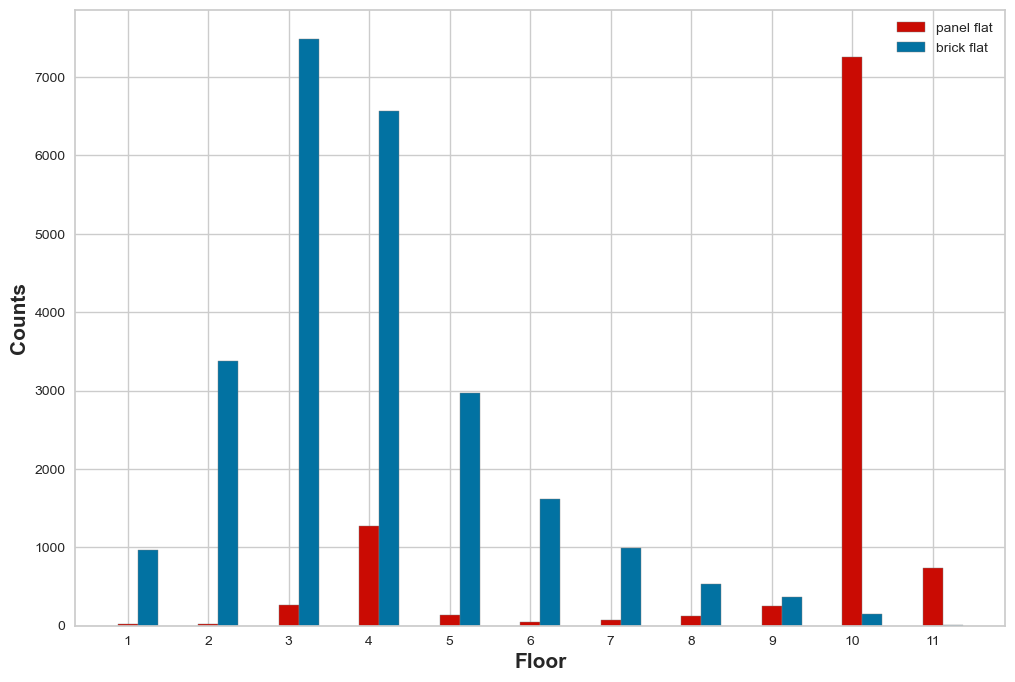

In [1774]:

x1 = df_floor_stat['building_floor_count'].where(df_floor_stat['property_subtype']==2)
x2 = df_floor_stat['building_floor_count'].where(df_floor_stat['property_subtype']==1)

y1 = df_floor_stat['counts'].where(df_floor_stat['property_subtype']==2)
y2 = df_floor_stat['counts'].where(df_floor_stat['property_subtype']==1)

barWidth = 0.25
fig = plt.subplots(figsize =(12, 8))

plt.bar(x1, y1, color ='r', width = barWidth,
        edgecolor ='grey', label ='panel flat')

plt.bar(x2+barWidth, y2, color ='b', width = barWidth,
        edgecolor ='grey', label ='brick flat')

plt.xlabel('Floor', fontweight ='bold', fontsize = 15)
plt.ylabel('Counts', fontweight ='bold', fontsize = 15)
plt.xticks([r+1 for r in range(11)],
        ['1', '2', '3', '4','5','6','7', '8', '9', '10', '11'])
plt.legend()
plt.show()


# jól látható, hog a panel flat esetén szinte mindig 10 emeletes épületekről van szó, míg a brick flat esetén 3-4
# a hiányzó értékeknél a building_floor_count-hoz ezek függvényében írok 10 vagy 4-et. Ha a propperty_floor nagyobb, akkor az adott sor property_floor értékét kapja meg

In [1776]:
## eredeti adathalmazból írom át
df_shuffle['emelet'].fillna(df['property_subtype'],inplace = True)

In [1781]:
df_shuffle['emelet'].value_counts()
# most átírom a szövegnek megfelelően brick flat == 4, panel flat == 10

1      14687
2      12890
0      12346
3      10716
4       9356
0.5     3677
5       3492
10      3155
6       2530
7       1841
8       1712
9       1615
-1       441
Name: emelet, dtype: int64

In [1778]:
def switch_str_to_floor(x):
    if x=='brick flat (for sale)':
        x='4'
    elif x =='prefabricated panel flat (for sale)':
        x='10'
    return x

In [1780]:
df_shuffle['emelet'] = df_shuffle['emelet'].apply(lambda x: switch_str_to_floor(x))

In [1782]:
df_shuffle['emelet'].isna().sum()
# azok a sorok ahol sem subtype sem building_floor_count érték nincsen megadva, 

81

In [1784]:
df_shuffle['emelet_epulet'] = df_shuffle['building_floor_count'].copy()

In [1785]:
## az épület emeletszámát a property_floor értékeivel töltöm ki, mert legalább annyi emelet biztosan van
df_shuffle['emelet_epulet'].fillna(df_shuffle['emelet'],inplace = True)

In [1786]:
df_shuffle['emelet_epulet'].isna().sum()

51

In [1787]:
# a fennmaradó 51 üres helyre , ahol a fentebb felsorolt oszlopok mindegyikében Nan található, az emeletek median értékét írom
df_shuffle['emelet_epulet'].fillna(df_shuffle['emelet_epulet'].median(),inplace = True)

In [1788]:
print(df_shuffle['emelet_epulet'].isna().sum())
print(df_shuffle['emelet'].isna().sum())

0
81


In [1789]:
# az olyan sorokat, ahol a lakás emeletének értéke ismeretlen az épület emeletszámával töltöm ki.
df_shuffle['emelet'].fillna(df_shuffle['emelet_epulet'],inplace = True)


In [1790]:
df_shuffle['emelet']=df_shuffle['emelet'].astype(str).astype(float)
df_shuffle['emelet_epulet']=df_shuffle['emelet_epulet'].astype(str).astype(float)

In [1791]:
df_shuffle.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 78539 entries, 0 to 78538
Data columns (total 61 columns):
 #   Column                                            Non-Null Count  Dtype         
---  ------                                            --------------  -----         
 0   active_days                                       78539 non-null  float64       
 1   heating_type                                      78539 non-null  object        
 2   small_room_cnt                                    78539 non-null  float64       
 3   property_condition_type                           78539 non-null  object        
 4   balcony_area                                      78539 non-null  float64       
 5   trend_nmAr                                        78539 non-null  float64       
 6   nmAr                                              78539 non-null  float64       
 7   room_cnt                                          78539 non-null  float64       
 8   postcode                  

##### 2. Üres helyek medián értékekkel való kitöltése

In [1792]:
df_shuffle['emelet_median'] = df_shuffle[['property_floor']].copy()

In [1793]:
## stringek átalakítás
df_shuffle['emelet_median'] = df_shuffle['emelet_median'].apply(lambda x: switch(x))

In [1794]:
# medián számítás előtt float típusra alakítás, hogy összevonja a tagokat, és ne tegyen különbséget objectum(2) és float(2.0) között
df_shuffle['emelet_median']=df_shuffle['emelet_median'].astype(str).astype(float)

In [ ]:
df_shuffle['emelet_median'] = df_shuffle['emelet_median'].fillna(df_shuffle['emelet_median'].median())

#### Modellellenőrzések a megfelelő változó kiválasztásához - Emelet

##### 1. Összefüggő változók

In [1796]:
bemeno_valtozok_test = bemeneti_valtozok.copy()

In [1797]:
bemeno_valtozok_test.insert(len(bemeno_valtozok_test),'emelet')

In [1798]:
result = modellezes_linreg(df_shuffle,bemeno_valtozok_test,'jelen_nmAr')
save_result(result,'floor_from_other','linreg')

{'fit_time': array([0.04786587, 0.0498631 , 0.05086422]), 'score_time': array([0.00598526, 0.00797963, 0.00498652]), 'test_score': array([0.22730869, 0.23191261, 0.23533695])}


In [1799]:
result = modellezes_gbm(df_shuffle,bemeno_valtozok_test,'jelen_nmAr')
save_result(result,'floor_from_other','gbm')

{'fit_time': array([6.68911004, 6.38494635, 6.50156617]), 'score_time': array([0.05085945, 0.05285788, 0.05585074]), 'test_score': array([0.15138162, 0.15536563, 0.15858429])}


##### 2. Medián érték

In [1800]:
bemeno_valtozok_test_median = bemeneti_valtozok.copy()

In [1801]:
bemeno_valtozok_test_median.insert(len(bemeno_valtozok_test_median),'emelet_median')

In [1802]:
result = modellezes_linreg(df_shuffle,bemeno_valtozok_test_median,'jelen_nmAr')
save_result(result,'floor_from_median','linreg')

{'fit_time': array([0.04687524, 0.05585074, 0.04587531]), 'score_time': array([0.00698137, 0.00498986, 0.00598478]), 'test_score': array([0.22736102, 0.23200862, 0.23545802])}


In [1803]:
result = modellezes_gbm(df_shuffle,bemeno_valtozok_test_median,'jelen_nmAr')
save_result(result,'floor_from_median','gbm')

{'fit_time': array([6.70111322, 6.55444503, 6.53548956]), 'score_time': array([0.05581141, 0.05186081, 0.05190134]), 'test_score': array([0.14979252, 0.15564143, 0.15939353])}


In [1804]:
## egy ezreléknyi eltérés a két átalakítás között
bemeneti_valtozok.insert(len(bemeneti_valtozok),'emelet')

In [1805]:
bemeneti_valtozok

['heating_type=_central heating with own meter',
 'heating_type=_district heating',
 'heating_type=_electric',
 'heating_type=_fan-coil',
 'heating_type=_gas furnace',
 'heating_type=_gas furnace, circulating hot water',
 'heating_type=_konvection gas burner',
 'heating_type=_other',
 'heating_type=_tile stove (gas)',
 'small_room_cnt',
 'condition=_good',
 'condition=_medium',
 'condition=_missing_info',
 'condition=_new_construction',
 'condition=_novel',
 'condition=_renewed',
 'condition=_to_be_renovated',
 'condition=_under_construction',
 'balcony_area',
 'room_cnt',
 'ker_code_from_postcode',
 'year',
 'month',
 'day',
 'property_subtype',
 'view_type',
 'elevator_type',
 'garden_access',
 'property_area',
 'emelet']

#### Épület emeletszáma
##### 42110 NaN érték

In [1812]:
df_shuffle['building_floor_count'].value_counts()

4     8298
3     7810
10    7698
2     3411
5     3176
6     1702
7     1132
1      992
11     834
8      689
9      687
Name: building_floor_count, dtype: int64

In [1813]:
# stringek átalakítás
df_shuffle['building_floor_count'] = df_shuffle['building_floor_count'].apply(lambda x: switch(x))

##### Minden épületnek legalább annyi emelete van, mint ahányadik szinten van a lakás
##### Ellentmondások javítása

In [1826]:
df_shuffle[df_shuffle['emelet_epulet']<df_shuffle['emelet']]

,active_days,heating_type,small_room_cnt,property_condition_type,balcony_area,trend_nmAr,nmAr,room_cnt,postcode,county,...,ori=_north-east,ori=_north-west,ori=_south,ori=_south-east,ori=_south-west,ori=_west,roman,emelet,emelet_epulet,emelet_median
46,43.0,konvection gas burner,0.0,new_construction,0.0,311324.872196,271428.571429,1.0,20,Budapest,...,0,0,0,0,1,0,XX,4.0,1.0,2.0
141,18.0,konvection gas burner,0.0,good,0.0,311577.040554,330000.000000,1.0,6,Budapest,...,0,0,0,1,0,0,VI,4.0,3.0,2.0
144,69.0,konvection gas burner,0.0,medium,0.0,311577.040554,351666.666667,2.0,3,Budapest,...,0,0,0,0,0,0,III,4.0,2.0,2.0
287,90.0,konvection gas burner,1.0,renewed,0.0,311577.040554,288888.888889,1.0,15,Budapest,...,0,0,0,0,1,0,XV,4.0,1.0,2.0
668,7.0,"gas furnace, circulating hot water",3.0,renewed,0.0,312333.545627,298333.333333,1.0,19,Budapest,...,0,0,0,1,0,0,XIX,4.0,1.0,2.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
77998,14.0,central heating,1.0,good,3.0,449513.132256,900000.000000,1.0,5,Budapest,...,0,0,0,0,0,0,V,4.0,2.0,2.0
78066,11.0,konvection gas burner,0.0,medium,0.0,449765.300614,264000.000000,1.0,0,Budapest,...,0,0,0,0,0,0,VIII,4.0,3.0,2.0
78216,3.0,"gas furnace, circulating hot water",2.0,missing_info,0.0,450773.974045,712857.142857,1.0,19,Budapest,...,0,0,1,0,0,0,XIX,4.0,2.0,2.0
78337,12.0,tile stove (gas),0.0,medium,0.0,451530.479118,342500.000000,1.0,0,Budapest,...,0,0,0,0,0,0,XXIV,4.0,3.0,2.0


In [1827]:
df_shuffle.loc[df_shuffle.emelet>df_shuffle.emelet_epulet, 'emelet_epulet'] = df_shuffle.emelet.astype(str).astype(float)

In [1828]:
df_shuffle['emelet_epulet'].isna().sum()

0

In [ ]:
# nincs több ellentmondás

In [1829]:
bemeneti_valtozok.insert(len(bemeneti_valtozok),'emelet_epulet')

In [ ]:
df_result = pd.read_csv('Result.csv')

# MLPRegressor értékelése, az egész adathalmaz átalakítása után

In [1835]:
result = modellezes_MLP_2(df_shuffle[bemeneti_valtozok],df_shuffle['jelen_nmAr'])
#save_result_nn(result,'floor_from_median','MLPReg')


In [1838]:
result_mean = result.mean()

In [ ]:
new_row = pd.DataFrame({'model':'MLPReg', 'new_feature_name':'floor_from_median', 'mape_score_mean':result_mean}, index=[0])
df_result = df_result.concat([new_row,df_result.loc[:]]).reset_index(drop=True)

# Modellek teljesítményének alakulás (MAPE)

In [1844]:
df_result

,model,new_feature_name,mape_score_mean
0,linreg,heating_type_dummy,0.284987
1,gbm,heating_type_dummy,0.284985
2,MLPReg,heating_type_dummy,0.288836
3,linreg,heating_type_citydummy,0.283079
4,gbm,heating_type_citydummy,0.283083
5,linreg,condition_dummy,0.268868
6,gbm,condition_dummy,0.262158
7,linreg,condition_mapping,0.280788
8,gbm,condition_mapping,0.262593
9,linreg,ker_code_from_postcode,0.283352


In [1845]:
linreg = df_result[df_result['model']=='linreg']
gbm = df_result[df_result['model']=='gbm']
MLPReg = df_result[df_result['model']=='MLPReg']


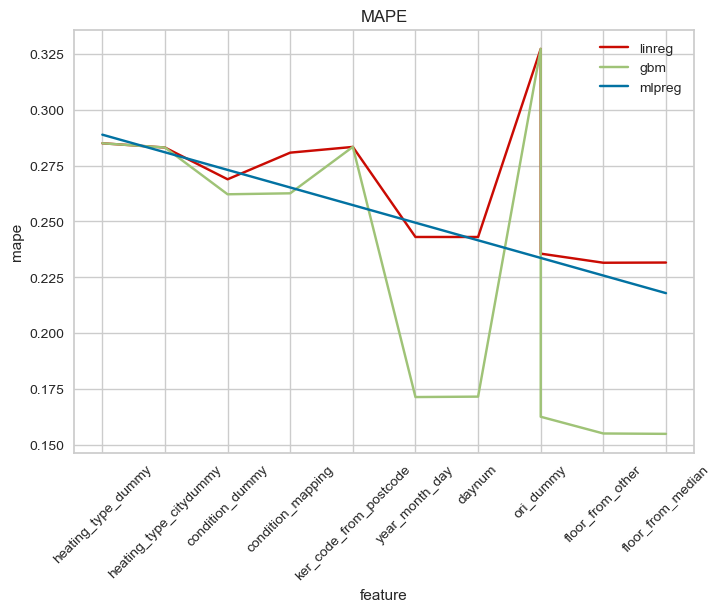

In [1847]:
plt.plot(linreg['new_feature_name'],linreg['mape_score_mean'], color='r', label='linreg')
plt.plot(gbm['new_feature_name'],gbm['mape_score_mean'], color='g', label='gbm')
plt.plot(MLPReg['new_feature_name'],MLPReg['mape_score_mean'], color='b', label='mlpreg')
plt.xlabel("feature")
plt.xticks(rotation=45)
plt.ylabel("mape")
plt.title("MAPE")
plt.legend()
plt.show()

In [1849]:
df_result.to_csv('Result_done.csv',index=False)

#### Az eredményekből jól látható, hogy az egyes változók, hogyan alakítottak az értékeket
#### Az MLPRegressziót csak 2x futtattam, hogy ne vegyen el sok időt minden egyes változtatás utáni futtatás
#### A legtöbb jellemző hozzáadásával javult a modell teljesítménye, a mape értékek alapján
#### Ezekk alpján a következő változók szükségesek a tanításhoz:

In [1850]:
bemeneti_valtozok

['heating_type=_central heating with own meter',
 'heating_type=_district heating',
 'heating_type=_electric',
 'heating_type=_fan-coil',
 'heating_type=_gas furnace',
 'heating_type=_gas furnace, circulating hot water',
 'heating_type=_konvection gas burner',
 'heating_type=_other',
 'heating_type=_tile stove (gas)',
 'small_room_cnt',
 'condition=_good',
 'condition=_medium',
 'condition=_missing_info',
 'condition=_new_construction',
 'condition=_novel',
 'condition=_renewed',
 'condition=_to_be_renovated',
 'condition=_under_construction',
 'balcony_area',
 'room_cnt',
 'ker_code_from_postcode',
 'year',
 'month',
 'day',
 'property_subtype',
 'view_type',
 'elevator_type',
 'garden_access',
 'property_area',
 'emelet',
 'emelet_epulet']

#### A legjobb teljesítményt elérő modell kétség kívűl a GradientBoostingRegressor volt
##### Futtattva a következő eredményre jutunk

In [1851]:
def modellezes3(model,train_df,test_df, bemeno_valtozok, celvaltozo):
    model.fit(train_df[bemeno_valtozok], train_df[celvaltozo])
    test_df['tipp']=model.predict(test_df[bemeno_valtozok])
    return test_df

In [1852]:
model_gbm=GradientBoostingRegressor(n_estimators=100,max_depth=4,random_state=42)

RMSE 143633.4005536277
MAE: 74372.25909125553
MAPE: 0.15005232285622783
atnezendok aranya 0.35898905016552074


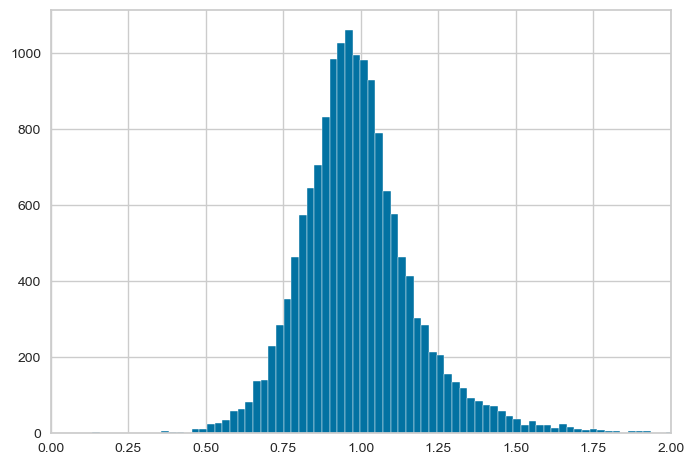

In [1855]:
train_df,test_df = train_test_split(df_shuffle,test_size=0.2,random_state=42)
test_df=modellezes3(model_gbm,train_df,test_df,bemeneti_valtozok,'jelen_nmAr')
erdekesek = kiertekelo_fuggveny(test_df,'tipp','jelen_nmAr')

In [1856]:
erdekesek

,active_days,heating_type,small_room_cnt,property_condition_type,balcony_area,trend_nmAr,nmAr,room_cnt,postcode,county,...,ori=_south,ori=_south-east,ori=_south-west,ori=_west,roman,emelet,emelet_epulet,emelet_median,tipp,tipp_arany
55380,3.0,konvection gas burner,0.0,missing_info,0.0,404627.164572,342222.222222,2.0,7,Budapest,...,0,1,0,0,VII,2.0,3.0,2.0,497614.115897,0.772160
24173,20.0,district heating,2.0,good,2.0,352428.314513,306153.846154,1.0,11,Budapest,...,0,0,0,1,XI,3.0,3.0,3.0,415974.575595,0.948744
51231,141.0,konvection gas burner,1.0,to_be_renovated,0.0,398322.955628,280000.000000,1.0,0,Budapest,...,0,0,0,0,VIII,2.0,3.0,2.0,340549.436255,0.937755
28503,11.0,"gas furnace, circulating hot water",0.0,novel,0.0,361002.038677,410000.000000,2.0,8,Budapest,...,0,0,0,0,VIII,1.0,1.0,1.0,562240.087044,0.917697
49196,11.0,central heating,0.0,medium,5.0,395296.935335,330769.230769,2.0,7,Budapest,...,0,0,1,0,VII,4.0,4.0,2.0,487936.219309,0.779086
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
36255,8.0,konvection gas burner,1.0,medium,0.0,372097.446419,391666.666667,2.0,0,Budapest,...,0,0,1,0,I,0.5,0.5,0.5,572345.643201,0.835504
40380,29.0,"gas furnace, circulating hot water",2.0,medium,0.0,378401.655364,357142.857143,1.0,12,Budapest,...,0,0,1,0,XII,3.0,5.0,3.0,526138.229654,0.814959
18555,102.0,konvection gas burner,0.0,novel,0.0,343098.085275,416363.636364,2.0,2,Budapest,...,0,0,0,0,II,2.0,2.0,2.0,659293.986081,0.836223
76502,31.0,central heating with own meter,2.0,novel,0.0,443208.923312,455555.555556,1.0,14,Budapest,...,0,0,1,0,XIV,4.0,4.0,4.0,561686.064133,0.831354


In [1857]:
erdekesek.to_csv('results_C1MTMR.csv',index=False)